## Review

Hi Vladimir. This is Soslan again :). As always I've added all my comments to new cells with different coloring.

<div class="alert alert-success" role="alert">
  If you did something great I'm using green color for my comment
</div>

<div class="alert alert-warning" role="alert">
If I want to give you advice or think that something can be improved, then I'll use yellow. This is an optional recommendation.
</div>

<div class="alert alert-danger" role="alert">
  If the topic requires some extra work so I can accept it then the color will be red
</div>

You did a good project. Nice chart, good structured easy to read code, helper functions. Everything is OK. I have just one remark about using cross-validation with upsampling. But because your final score is good enough, I can accept your project. Just have a look at my comments. Good luck.

---

## Project description

<div class="paragraph">Beta Bank customers are leaving: little by little, chipping away every month. The bankers figured out it’s cheaper to save the existing customers rather than to attract new ones.</div><div class="paragraph">We need to predict whether a customer will leave the bank soon. You have the data on clients’ past behavior and termination of contracts with the bank.</div><div class="paragraph">Build a model with the maximum possible <em>F1</em> score. To pass the project, you need an <em>F1</em> score of at least 0.59. Check the <em>F1</em> for the test set.</div><div class="paragraph">Additionally, measure the <em>AUC-ROC</em> metric and compare it with the <em>F1</em>.</div></div>

### 1. Download and prepare the data. Explain the procedure.

<div class="markdown markdown_size_normal markdown_type_theory"><strong>Features</strong><ul><li><em>RowNumber</em> — data string index</li><li><em>CustomerId</em> — unique customer identifier</li><li><em>Surname</em> — surname</li><li><em>CreditScore</em> — credit score</li><li><em>Geography</em> — country of residence</li><li><em>Gender</em> — gender</li><li><em>Age</em> — age</li><li><em>Tenure</em> — period of maturation for a customer’s fixed deposit (years)</li><li><em>Balance</em> — account balance</li><li><em>NumOfProducts</em> — number of banking products used by the customer</li><li><em>HasCrCard</em> — customer has a credit card</li><li><em>IsActiveMember</em> — customer’s activeness</li><li><em>EstimatedSalary</em> — estimated salary</li></ul><div class="paragraph"><strong>Target</strong></div><ul><li><em>Exited</em> — сustomer has left</li></ul></div>

In [117]:
!pip install catboost -q

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import *
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import *
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, LogisticRegressionCV
from sklearn.utils import shuffle
from catboost import CatBoostClassifier
import random
random.seed(42)
np.random.seed(42)
import warnings
warnings.filterwarnings('ignore')
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

In [119]:
def display_classification_report(y_true, y_pred):
    display(pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T)

In [120]:
def plot_roc(y_test, preds, ax=None, label='model'):
    with plt.style.context('seaborn-whitegrid'):
        if not ax: fig, ax = plt.subplots(1, 1)
        fpr, tpr, thresholds = roc_curve(y_test, preds)
        ax.plot([0, 1], [0, 1],'r--')
        ax.plot(fpr, tpr, lw=2, label=label)
        ax.legend(loc='lower right')
        ax.set_title(
             'ROC curve\n'
            f""" AP: {average_precision_score(
                y_test, preds, pos_label=1
            ):.2} | """
            f'AUC: {auc(fpr, tpr):.2}')
        ax.set_xlabel('False Positive Rate (FPR)')
        ax.set_ylabel('True Positive Rate (TPR)')
        ax.annotate(f'AUC: {auc(fpr, tpr):.2}', xy=(.43, .025))
        ax.legend()
        ax.grid()
        return ax
    

def plot_pr(y_test, preds, ax=None, label='model'):
    with plt.style.context('seaborn-whitegrid'):
        precision, recall, thresholds = precision_recall_curve(y_test, preds)
        if not ax: fig, ax = plt.subplots()
        ax.plot([0, 1], [1, 0],'r--')    
        ax.plot(recall, precision, lw=2, label=label)
        ax.legend()
        ax.set_title(
            'Precision-recall curve\n'
            f""" AP: {average_precision_score(
                y_test, preds, pos_label=1
            ):.2} | """
            f'AUC: {auc(recall, precision):.2}'
        )
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.set_xlim(-0.05, 1.05)
        ax.set_ylim(-0.05, 1.05)
        ax.legend()
        ax.grid()
        return ax

In [121]:
#missing value ratio
def missing_values(df):
    df_nulls=pd.concat([df.dtypes, df.isna().sum(), df.isna().sum()/len(df)], axis=1)
    df_nulls.columns = ["type","count","missing_ratio"]
    df_nulls=df_nulls[df_nulls["count"]>0]
    df_nulls.sort_values(by="missing_ratio", ascending=False)
    return df_nulls

#outliers by 3 sigma rule
def outlier(data):
    data_mean, data_std = np.mean(data), np.std(data)
    cut_off = data_std * 3
    lower, upper = data_mean - cut_off, data_mean + cut_off
    outliers = [x for x in data if x < lower or x > upper]
    outliers_removed = [x for x in data if x >= lower and x <= upper]
    return len(outliers)

# full description statistics 
def describe_full(df, target_name=""):
    data_describe = df.describe().T
    df_numeric = df._get_numeric_data()
    if target_name in df.columns:
        corr_with_target=df_numeric.drop(target_name, axis=1).apply(lambda x: x.corr(df_numeric[target_name]))
        data_describe['corr_with_target']=corr_with_target
    dtype_df = df_numeric.dtypes
    data_describe['dtypes'] = dtype_df
    data_null = df_numeric.isnull().sum()/len(df) * 100
    data_describe['Missing %'] = data_null
    Cardinality = df_numeric.apply(pd.Series.nunique)
    data_describe['Cardinality'] = Cardinality
    df_skew = df_numeric.skew(axis=0, skipna=True)
    data_describe['Skew'] = df_skew
    data_describe['outliers']=[outlier(df_numeric[col]) for col in df_numeric.columns]
    data_describe['kurtosis']=df_numeric.kurtosis()
    return data_describe

<div class="alert alert-success" role="alert">
Great, nice helper functions</div>

In [122]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/Churn.csv')

In [123]:
df = shuffle(df, random_state=42)

In [124]:
features = ['CreditScore', 'Geography','Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary']
target = 'Exited'

In [125]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 6252 to 7270
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [126]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
6252,6253,15687492,Anderson,596,Germany,Male,32,3.0,96709.07,2,0,0,41788.37,0
4684,4685,15736963,Herring,623,France,Male,43,1.0,0.00,2,1,1,146379.30,0
1731,1732,15721730,Amechi,601,Spain,Female,44,4.0,0.00,2,1,0,58561.31,0
4742,4743,15762134,Liang,506,Germany,Male,59,8.0,119152.10,2,1,1,170679.74,0
4521,4522,15648898,Chuang,560,Spain,Female,27,7.0,124995.98,1,1,1,114669.79,0


In [127]:
df['Gender'] = (df['Gender']=='Female').astype(int)

In [128]:
df.isna().sum()

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

In [129]:
df = df.drop(['RowNumber'], axis=1)

In [130]:
le_geo = LabelEncoder()
df['Geography'] = le_geo.fit_transform(df['Geography'])

In [131]:
len(df['Surname'].unique())

2932

In [132]:
df = df.drop(['CustomerId', 'Surname'], axis=1)

In [133]:
df[df['Tenure'].isna()]

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
576,439,2,1,32,NaN,138901.61,1,1,0,75685.97,0
8158,641,0,1,37,NaN,0.00,2,1,0,3939.87,0
9485,850,2,0,37,NaN,88141.10,1,1,0,109659.12,0
1963,578,1,0,34,NaN,147487.23,2,1,0,66680.77,0
9655,583,0,1,40,NaN,55776.39,2,1,0,26920.43,0
...,...,...,...,...,...,...,...,...,...,...,...
3073,531,1,1,32,NaN,109570.21,2,1,1,172049.84,0
8792,497,0,0,34,NaN,0.00,2,1,1,83087.13,0
7734,713,0,0,41,NaN,0.00,2,1,0,55772.04,0
9274,560,2,1,33,NaN,0.00,1,0,1,183358.21,0


In [134]:
df[df['Tenure'].isna()][target].value_counts()

0    726
1    183
Name: Exited, dtype: int64

as we saw , we have missing data at the 'tenure' column, around 10%, in my opinion, it's a lot for dropping, especially if we have positive class value in imbalancing case

let's impute it, using linear regression (without label for avoiding leakage)

In [135]:
parameters = set(df.columns) - set([target, 'Tenure'])
test_data = df[df['Tenure'].isna()]
train_data = df[~df['Tenure'].isna()]
X = train_data[parameters].values
y = train_data['Tenure'].values
X_test, y_test = test_data[parameters].values, test_data['Tenure'].values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)
lr = LinearRegression().fit(X_train, y_train)
y_pred = lr.predict(X_val).astype(int)
mean_squared_error(y_val, y_pred)

9.228571428571428

<div class="alert alert-success" role="alert">
Good solution</div>

In [136]:
df.loc[df['Tenure'].isna(), 'Tenure'] = lr.predict(X_test).astype(int)

In [137]:
df['Tenure'] = df['Tenure'].astype(int)

In [138]:
describe_full(df, target)

,count,mean,std,min,25%,50%,75%,max,corr_with_target,dtypes,Missing %,Cardinality,Skew,outliers,kurtosis
CreditScore,10000.0,650.528800,96.653299,350.00,584.00,652.000,718.0000,850.00,-0.027094,int64,0.0,460,-0.071607,8,-0.425726
Geography,10000.0,0.746300,0.827529,0.00,0.00,0.000,1.0000,2.00,0.035943,int64,0.0,3,0.500916,0,-1.360998
Gender,10000.0,0.454300,0.497932,0.00,0.00,0.000,1.0000,1.00,0.106512,int64,0.0,2,0.183596,0,-1.966686
Age,10000.0,38.921800,10.487806,18.00,32.00,37.000,44.0000,92.00,0.285323,int64,0.0,70,1.011320,133,1.395347
Tenure,10000.0,4.955200,2.767374,0.00,3.00,5.000,7.0000,10.00,-0.015769,int64,0.0,11,0.060880,0,-0.999930
Balance,10000.0,76485.889288,62397.405202,0.00,0.00,97198.540,127644.2400,250898.09,0.118533,float64,0.0,6382,-0.141109,0,-1.489412
NumOfProducts,10000.0,1.530200,0.581654,1.00,1.00,1.000,2.0000,4.00,-0.047820,int64,0.0,4,0.745568,60,0.582981
HasCrCard,10000.0,0.705500,0.455840,0.00,0.00,1.000,1.0000,1.00,-0.007138,int64,0.0,2,-0.901812,0,-1.186973
IsActiveMember,10000.0,0.515100,0.499797,0.00,0.00,1.000,1.0000,1.00,-0.156128,int64,0.0,2,-0.060437,0,-1.996747
EstimatedSalary,10000.0,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48,0.012097,float64,0.0,9999,0.002085,0,-1.181518


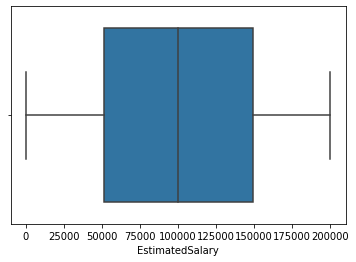

In [139]:
sns.boxplot(df['EstimatedSalary'])

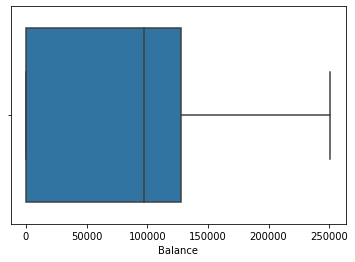

In [140]:
sns.boxplot(df['Balance'])

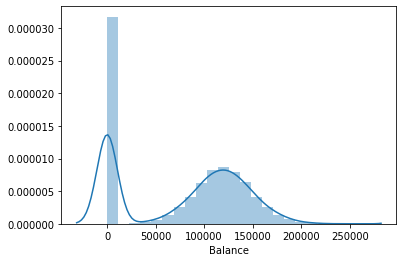

In [141]:
sns.distplot(df['Balance'])

Let's see most important features

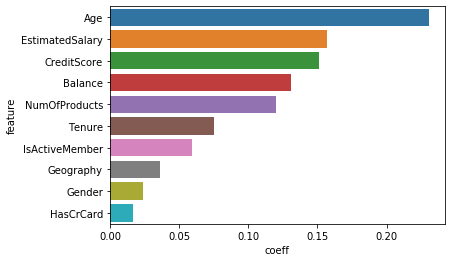

In [142]:
X, y = df[features].values,df[target].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
rfc = DecisionTreeClassifier().fit(X_train, y_train)
y_pred = rfc.predict(X_test)
df_feature_importances = pd.DataFrame(((zip(features, rfc.feature_importances_)))).rename(columns={0:"feature",1:"coeff"}).sort_values(by="coeff", ascending = False )
sns.barplot(data=df_feature_importances, x=df_feature_importances["coeff"], y=df_feature_importances["feature"])

features sorted by importance

In [143]:
features = list(df_feature_importances["feature"])
features

['Age',
 'EstimatedSalary',
 'CreditScore',
 'Balance',
 'NumOfProducts',
 'Tenure',
 'IsActiveMember',
 'Geography',
 'Gender',
 'HasCrCard']

In [144]:
del X, y, X_test, y_test, X_train, y_train, X_val, y_val

### Summary

Our data consists from 14 features, where we found out that RowNumber, CustomerId and Surname are not important (don't impact on the model) features by importance: 'Age','EstimatedSalary','Balance','CreditScore','NumOfProducts',
 'Tenure','IsActiveMember','Geography','Gender','HasCrCard'.
 Our target is 'Exited'. Also we have Balance, EstimatedSalary and good questiong what is meause of those columns(we could infer it from column of Geography, if it's Europe probably it's euro). Also some data was missed at Tenure column, but using some simplistic model (linear regression) we imputed it. 

<div class="alert alert-success" role="alert">
Excellent data analysis and preparation.</div>

### 2. Examine the balance of classes. Train the model without taking into account the imbalance. Briefly describe your findings.

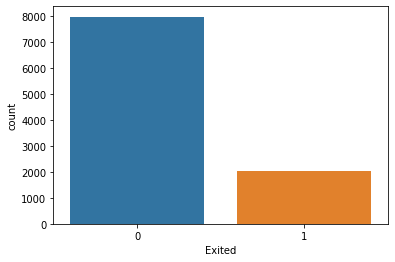

In [145]:
sns.countplot(df[target])

In [146]:
display(df[target].value_counts())
100*df[target].value_counts()/len(df)

0    7963
1    2037
Name: Exited, dtype: int64

0    79.63
1    20.37
Name: Exited, dtype: float64

as we see classes are imbalanced

#### Logistic regresion

In [147]:
history = dict()

In [148]:
X, y = df[features].values, df[target].values

<div class="alert alert-warning" role="alert">
You could also scale your numeric features.</div>

In [149]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [150]:
lr = LogisticRegressionCV(cv=5, random_state=42).fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [151]:
display_classification_report(y_test, y_pred)

,precision,recall,f1-score,support
0,0.802860,0.985580,0.884886,1595.0000
1,0.452381,0.046914,0.085011,405.0000
accuracy,0.795500,0.795500,0.795500,0.7955
macro avg,0.627621,0.516247,0.484949,2000.0000
weighted avg,0.731888,0.795500,0.722911,2000.0000


In [152]:
#as we saw in the table, for f1 we got very bad result
history['linear_imbalanced'] = f1_score(y_test, y_pred)
f1_score(y_test, y_pred)

0.08501118568232663

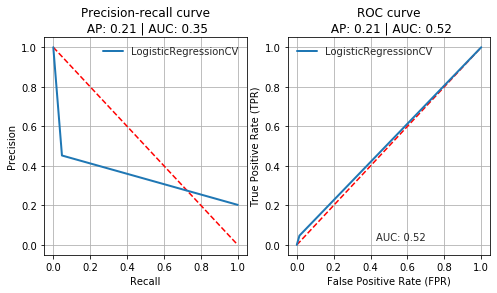

In [153]:
fig, ax = plt.subplots(1,2, figsize=(8,4))
ax = ax.flatten()
plot_pr(y_test, y_pred, ax=ax[0],label="LogisticRegressionCV")
plot_roc(y_test, y_pred, ax=ax[1],label="LogisticRegressionCV")

<div class="alert alert-success" role="alert">
Nice charts</div>

0.809
[[1552   43]
 [ 339   66]]


,precision,recall,f1-score,support
0,0.820730,0.973041,0.890419,1595.000
1,0.605505,0.162963,0.256809,405.000
accuracy,0.809000,0.809000,0.809000,0.809
macro avg,0.713117,0.568002,0.573614,2000.000
weighted avg,0.777147,0.809000,0.762113,2000.000


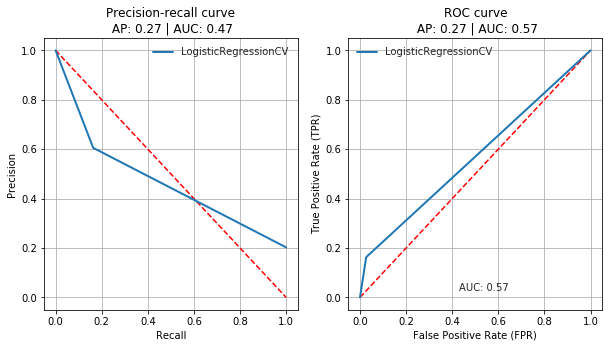

In [154]:
lrcv = LogisticRegressionCV(
    Cs=[0.1,1,10], penalty='l2', tol=1e-10, scoring='neg_log_loss', cv=5,
    solver='liblinear', n_jobs=4, verbose=0, refit=True,
    max_iter=100,
).fit(X_train, y_train)
y_pred = lrcv.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
display_classification_report(y_test, y_pred)

_, axs = plt.subplots(1, 2,figsize=(10,5))
axs = axs.ravel()
plot_pr(y_test, y_pred, ax=axs[0], label="LogisticRegressionCV")
plot_roc(y_test, y_pred, ax=axs[1], label="LogisticRegressionCV")

without dealing with imbalancing , we've got very poor model, the same, more or less than baseline, random model(i would like worser, because using random guessing according with fractions weights, random model would be better)

#### DecisionTreeClassifier

In [155]:
params = {
"criterion":["gini", "entropy"],
"max_depth":[2,4,8,16],
"min_samples_split":[2,4,8, 16],
"min_samples_leaf":[2,4,6]}
clf = GridSearchCV(DecisionTreeClassifier(), params, cv=5).fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(clf.score(X_train, y_train))
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
display_classification_report(y_test, y_pred)

0.872375
0.8515
[[1534   61]
 [ 236  169]]


,precision,recall,f1-score,support
0,0.866667,0.961755,0.911738,1595.0000
1,0.734783,0.417284,0.532283,405.0000
accuracy,0.851500,0.851500,0.851500,0.8515
macro avg,0.800725,0.689520,0.722011,2000.0000
weighted avg,0.839960,0.851500,0.834899,2000.0000


In [156]:
f1_score(y_test, y_pred)

0.5322834645669292

0.872375
0.8515
[[1534   61]
 [ 236  169]]


,precision,recall,f1-score,support
0,0.866667,0.961755,0.911738,1595.0000
1,0.734783,0.417284,0.532283,405.0000
accuracy,0.851500,0.851500,0.851500,0.8515
macro avg,0.800725,0.689520,0.722011,2000.0000
weighted avg,0.839960,0.851500,0.834899,2000.0000


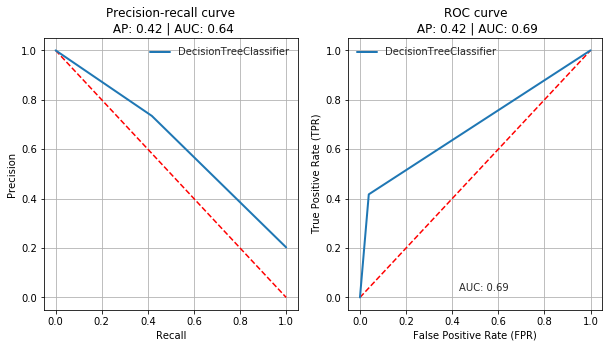

In [157]:
dt = DecisionTreeClassifier(**clf.best_params_).fit(X_train, y_train)
y_pred = dt.predict(X_test)
print(dt.score(X_train, y_train))
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
display_classification_report(y_test, y_pred)

_, axs = plt.subplots(1, 2,figsize=(10,5))
axs = axs.ravel()
plot_pr(y_test, y_pred, ax=axs[0], label="DecisionTreeClassifier")
plot_roc(y_test, y_pred, ax=axs[1], label="DecisionTreeClassifier")

In [158]:
history['desicion_tree_imbalanced'] = f1_score(y_test, y_pred)
f1_score(y_test, y_pred)

0.5322834645669292

#### CatBoostClassifier

0.919625
0.8565
[[1528   67]
 [ 220  185]]


,precision,recall,f1-score,support
0,0.874142,0.957994,0.914149,1595.0000
1,0.734127,0.456790,0.563166,405.0000
accuracy,0.856500,0.856500,0.856500,0.8565
macro avg,0.804134,0.707392,0.738657,2000.0000
weighted avg,0.845789,0.856500,0.843075,2000.0000


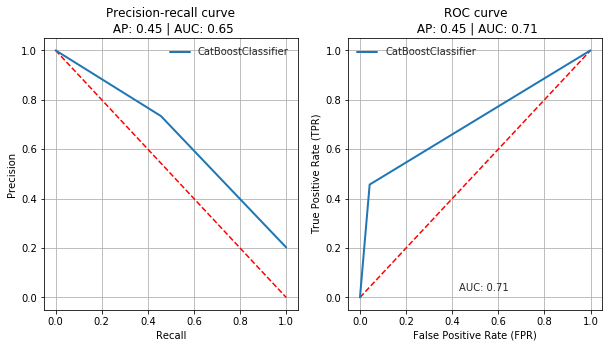

In [159]:
cb = CatBoostClassifier(verbose=0, random_state=42).fit(X_train, y_train)
y_pred = cb.predict(X_test)
print(cb.score(X_train, y_train))
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
display_classification_report(y_test, y_pred)

_, axs = plt.subplots(1, 2,figsize=(10,5))
axs = axs.ravel()
plot_pr(y_test, y_pred, ax=axs[0], label="CatBoostClassifier")
plot_roc(y_test, y_pred, ax=axs[1], label="CatBoostClassifier")

In [160]:
history['catboost_imbalanced'] = f1_score(y_test, y_pred)
f1_score(y_test, y_pred)

0.563165905631659

<div class="alert alert-success" role="alert">
Good research of models without balancing.</div>

### 3. Improve the quality of the model. Make sure you use at least two approaches to fixing class imbalance. Use the training set to pick the best parameters. Train different models on training and validation sets. Find the best one. Briefly describe your findings.

### Linear regression

0.705
[[1136  459]
 [ 131  274]]


,precision,recall,f1-score,support
0,0.896606,0.712226,0.793850,1595.000
1,0.373806,0.676543,0.481547,405.000
accuracy,0.705000,0.705000,0.705000,0.705
macro avg,0.635206,0.694384,0.637699,2000.000
weighted avg,0.790739,0.705000,0.730609,2000.000


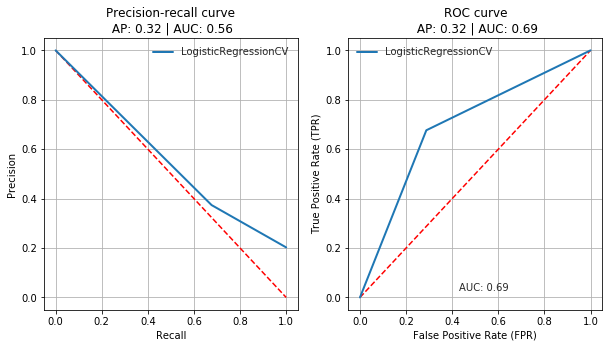

In [161]:
lrcv = LogisticRegressionCV(
    Cs=[0.1,1,10], class_weight='balanced', penalty='l2', tol=1e-10, scoring='neg_log_loss', cv=5,
    solver='liblinear', n_jobs=4, verbose=0, refit=True,
    max_iter=100,
).fit(X_train, y_train)
y_pred = lrcv.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
display_classification_report(y_test, y_pred)

_, axs = plt.subplots(1, 2,figsize=(10,5))
axs = axs.ravel()
plot_pr(y_test, y_pred, ax=axs[0], label="LogisticRegressionCV")
plot_roc(y_test, y_pred, ax=axs[1], label="LogisticRegressionCV")

In [162]:
history['linear'] = f1_score(y_test, y_pred)
f1_score(y_test, y_pred)

0.4815465729349737

we got much better result compare with previous result of the f1 metric, without balancing

### DecisionTreeClassifier

In [163]:
params = {
"class_weight":['balanced'],
"criterion":["gini", "entropy"],
"max_depth":[2,4,8,16],
"min_samples_split":[2,4,8, 16],
"min_samples_leaf":[2,4,6]}
clf = GridSearchCV(DecisionTreeClassifier(), params, cv=5).fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(clf.score(X_train, y_train))
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
display_classification_report(y_test, y_pred)

0.94675
0.7705
[[1318  277]
 [ 182  223]]


,precision,recall,f1-score,support
0,0.878667,0.826332,0.851696,1595.0000
1,0.446000,0.550617,0.492818,405.0000
accuracy,0.770500,0.770500,0.770500,0.7705
macro avg,0.662333,0.688475,0.672257,2000.0000
weighted avg,0.791052,0.770500,0.779023,2000.0000


0.946375
0.7685
[[1317  278]
 [ 185  220]]


,precision,recall,f1-score,support
0,0.876831,0.825705,0.850500,1595.0000
1,0.441767,0.543210,0.487265,405.0000
accuracy,0.768500,0.768500,0.768500,0.7685
macro avg,0.659299,0.684458,0.668883,2000.0000
weighted avg,0.788730,0.768500,0.776945,2000.0000


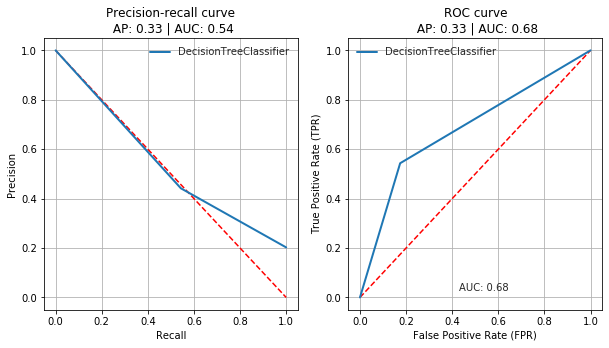

In [164]:
dt = DecisionTreeClassifier(**clf.best_params_).fit(X_train, y_train)
y_pred = dt.predict(X_test)
print(dt.score(X_train, y_train))
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
display_classification_report(y_test, y_pred)

_, axs = plt.subplots(1, 2,figsize=(10,5))
axs = axs.ravel()
plot_pr(y_test, y_pred, ax=axs[0], label="DecisionTreeClassifier")
plot_roc(y_test, y_pred, ax=axs[1], label="DecisionTreeClassifier")

In [165]:
history['desicion_tree'] = f1_score(y_test, y_pred)
f1_score(y_test, y_pred)

0.48726467331118495

### CatBoost

In [166]:
scale_pos_weight=(y_train==0).sum()/(y_train==1).sum()

0.901375
0.822
[[1375  220]
 [ 136  269]]


,precision,recall,f1-score,support
0,0.909993,0.862069,0.885383,1595.000
1,0.550102,0.664198,0.601790,405.000
accuracy,0.822000,0.822000,0.822000,0.822
macro avg,0.730048,0.763133,0.743586,2000.000
weighted avg,0.837115,0.822000,0.827955,2000.000


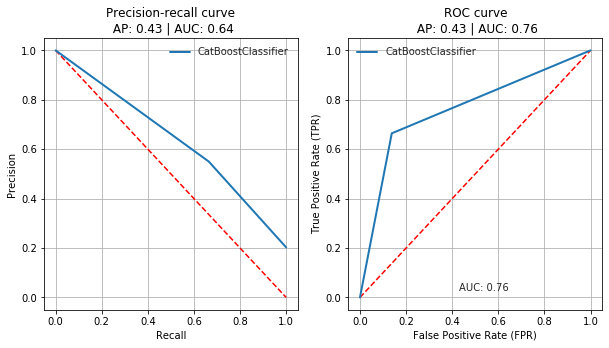

In [167]:
cb = CatBoostClassifier(verbose=0, scale_pos_weight=scale_pos_weight,random_state=42).fit(X_train, y_train)
y_pred = cb.predict(X_test)
print(cb.score(X_train, y_train))
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
display_classification_report(y_test, y_pred)

_, axs = plt.subplots(1, 2,figsize=(10,5))
axs = axs.ravel()
plot_pr(y_test, y_pred, ax=axs[0], label="CatBoostClassifier")
plot_roc(y_test, y_pred, ax=axs[1], label="CatBoostClassifier")

In [168]:
history['catboost'] = f1_score(y_test, y_pred)
f1_score(y_test, y_pred)

0.6017897091722595

In [169]:
history

{'linear_imbalanced': 0.08501118568232663,
 'desicion_tree_imbalanced': 0.5322834645669292,
 'catboost_imbalanced': 0.563165905631659,
 'linear': 0.4815465729349737,
 'desicion_tree': 0.48726467331118495,
 'catboost': 0.6017897091722595}

as we could see, we improved f1 metrics using weigths balancing technics

<div class="alert alert-success" role="alert">
Correct</div>


## Oversampling

we also could use imblearn package but let's do it from scratch

<div class="alert alert-warning" role="alert">
Using CV with upsampling/downsampling also required the custom realization of cross-validation. In case of default cross-validation you feed to CV balanced train set and only then model split it into train and validation parts. So your validation set is also balanced while you should choose a best model on unbalanced set as the nature of your data is such.</div>

Here an interesting article about it: https://kiwidamien.github.io/how-to-do-cross-validation-when-upsampling-data.html

---

In [170]:
def oversampling(features, target, repeat):
  features_zeros = features[target == 0]
  features_ones = features[target == 1]
  target_zeros = target[target == 0]
  target_ones = target[target == 1]
  features_resampled = features_zeros
  target_resampled = target_zeros
  for i in range(repeat):
    features_resampled = np.concatenate((features_resampled, features_ones), axis=0)
    target_resampled = np.concatenate((target_resampled, target_ones), axis=0)

  features_resampled, target_resampled = shuffle(features_resampled, target_resampled, random_state=42)
  return features_resampled, target_resampled

In [171]:
print((y_train==0).sum())
print((y_train==1).sum())
print((y_train==0).sum()//(y_train==1).sum())

6368
1632
3


In [172]:
X_resampled, y_resampled = oversampling(X_train, y_train, repeat=4)

In [173]:
print((y_resampled==0).sum())
print((y_resampled==1).sum())
print((y_resampled==0).sum()//(y_resampled==1).sum())

6368
6528
0


### Logisticregression

0.705
[[1136  459]
 [ 131  274]]


,precision,recall,f1-score,support
0,0.896606,0.712226,0.793850,1595.000
1,0.373806,0.676543,0.481547,405.000
accuracy,0.705000,0.705000,0.705000,0.705
macro avg,0.635206,0.694384,0.637699,2000.000
weighted avg,0.790739,0.705000,0.730609,2000.000


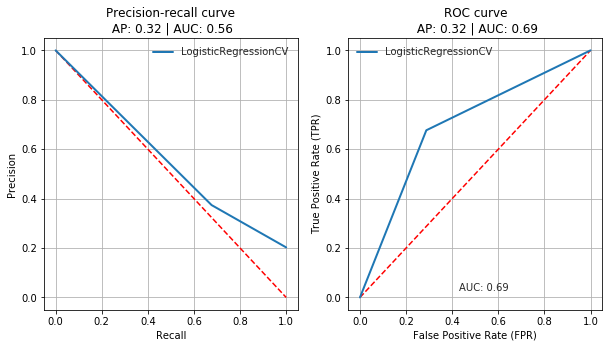

In [174]:
lrcv = LogisticRegressionCV(
    Cs=[0.1,1,10], class_weight='balanced', penalty='l2', tol=1e-10, scoring='neg_log_loss', cv=5,
    solver='liblinear', n_jobs=4, verbose=0, refit=True,
    max_iter=100,
).fit(X_resampled, y_resampled)
y_pred = lrcv.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
display_classification_report(y_test, y_pred)

_, axs = plt.subplots(1, 2,figsize=(10,5))
axs = axs.ravel()
plot_pr(y_test, y_pred, ax=axs[0], label="LogisticRegressionCV")
plot_roc(y_test, y_pred, ax=axs[1], label="LogisticRegressionCV")

In [175]:
print(f'without balancing={history["linear_imbalanced"]:.2f}')
print(f'with balancing={history["linear"]:.2f}')
print(f'using oversampling={f1_score(y_test, y_pred):.2f}')

without balancing=0.09
with balancing=0.48
using oversampling=0.48


### DecisionTreeClassifier

In [176]:
clf.best_score_

0.772875

In [177]:
params = {
"criterion":["gini", "entropy"],
"max_depth":[2,4,8,16],
"min_samples_split":[2,4,8, 16],
"min_samples_leaf":[2,4,6]}
clf = GridSearchCV(DecisionTreeClassifier(), params, cv=5).fit(X_resampled, y_resampled)
y_pred = clf.predict(X_test)
print(clf.score(X_resampled, y_resampled))
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
display_classification_report(y_test, y_pred)

0.9783653846153846
0.783
[[1348  247]
 [ 187  218]]


,precision,recall,f1-score,support
0,0.878176,0.845141,0.861342,1595.000
1,0.468817,0.538272,0.501149,405.000
accuracy,0.783000,0.783000,0.783000,0.783
macro avg,0.673497,0.691706,0.681246,2000.000
weighted avg,0.795281,0.783000,0.788403,2000.000


0.9783653846153846
0.7825
[[1348  247]
 [ 188  217]]


,precision,recall,f1-score,support
0,0.877604,0.845141,0.861067,1595.0000
1,0.467672,0.535802,0.499425,405.0000
accuracy,0.782500,0.782500,0.782500,0.7825
macro avg,0.672638,0.690472,0.680246,2000.0000
weighted avg,0.794593,0.782500,0.787834,2000.0000


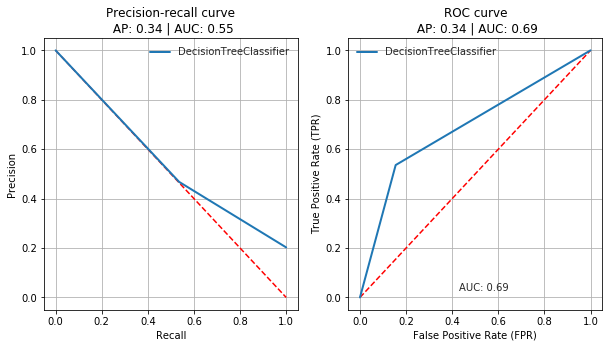

In [178]:
dt = DecisionTreeClassifier(**clf.best_params_).fit(X_resampled, y_resampled)
y_pred = dt.predict(X_test)
print(dt.score(X_resampled, y_resampled))
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
display_classification_report(y_test, y_pred)

_, axs = plt.subplots(1, 2,figsize=(10,5))
axs = axs.ravel()
plot_pr(y_test, y_pred, ax=axs[0], label="DecisionTreeClassifier")
plot_roc(y_test, y_pred, ax=axs[1], label="DecisionTreeClassifier")

In [179]:
print(f'without balancing={history["desicion_tree_imbalanced"]:.2f}')
print(f'with balancing={history["desicion_tree"]:.2f}')
print(f'using oversampling={f1_score(y_test, y_pred):.2f}')

without balancing=0.53
with balancing=0.49
using oversampling=0.50


### CatBoost


0.9267214640198511
0.8155
[[1374  221]
 [ 148  257]]


,precision,recall,f1-score,support
0,0.902760,0.861442,0.881617,1595.0000
1,0.537657,0.634568,0.582106,405.0000
accuracy,0.815500,0.815500,0.815500,0.8155
macro avg,0.720208,0.748005,0.731862,2000.0000
weighted avg,0.828826,0.815500,0.820966,2000.0000


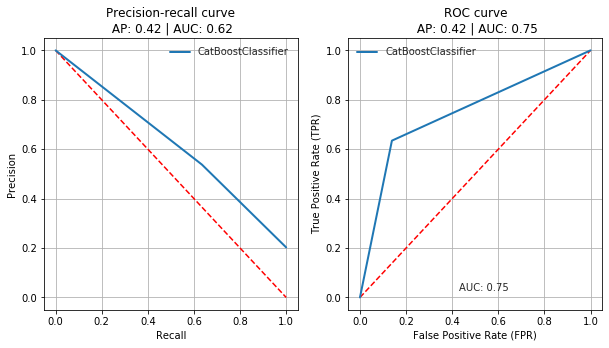

In [180]:
cb = CatBoostClassifier(verbose=0, random_state=42).fit(X_resampled, y_resampled)
y_pred = cb.predict(X_test)
print(cb.score(X_resampled, y_resampled))
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
display_classification_report(y_test, y_pred)

_, axs = plt.subplots(1, 2,figsize=(10,5))
axs = axs.ravel()
plot_pr(y_test, y_pred, ax=axs[0], label="CatBoostClassifier")
plot_roc(y_test, y_pred, ax=axs[1], label="CatBoostClassifier")

In [181]:
print(f'without balancing={history["catboost_imbalanced"]:.2f}')
print(f'with balancing={history["catboost"]:.2f}')
print(f'using oversampling={f1_score(y_test, y_pred):.2f}')

without balancing=0.56
with balancing=0.60
using oversampling=0.58


<div class="alert alert-success" role="alert">
Overall good third step but with keeping in mind a thougth about cv over balancing.</div>

also we could use undersampling

### 4. Perform the final testing.

best result we've got using CatBoost, using class weights balancing

0.901375
0.822
[[1375  220]
 [ 136  269]]


,precision,recall,f1-score,support
0,0.909993,0.862069,0.885383,1595.000
1,0.550102,0.664198,0.601790,405.000
accuracy,0.822000,0.822000,0.822000,0.822
macro avg,0.730048,0.763133,0.743586,2000.000
weighted avg,0.837115,0.822000,0.827955,2000.000


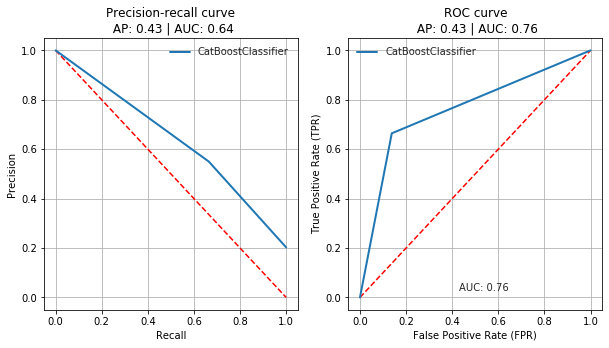

In [183]:
cb = CatBoostClassifier(verbose=0, scale_pos_weight=scale_pos_weight,random_state=42).fit(X_train, y_train)
y_pred = cb.predict(X_test)
print(cb.score(X_train, y_train))
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
display_classification_report(y_test, y_pred)

_, axs = plt.subplots(1, 2,figsize=(10,5))
axs = axs.ravel()
plot_pr(y_test, y_pred, ax=axs[0], label="CatBoostClassifier")
plot_roc(y_test, y_pred, ax=axs[1], label="CatBoostClassifier")

<div class="alert alert-success" role="alert">
Final test was done correctly.</div>

<div class="markdown markdown_size_normal markdown_type_theory"><h1>Project evaluation</h1><div class="paragraph">We’ve put together the evaluation criteria for the project. Read this carefully before moving on to the task.</div><div class="paragraph">Here’s what the reviewers will look at when reviewing your project:</div><ul><li>How did you prepare the data for training? Have you processed all of the feature types?</li><li>Have you explained the preprocessing steps well enough?</li><li>How did you investigate the balance of classes?</li><li>Did you study the model without taking into account the imbalance of classes?</li><li>What are your findings about the task research?</li><li>Have you correctly split the data into sets?</li><li>How have you worked with the imbalance of classes?</li><li>Did you use at least two techniques for imbalance fixing?</li><li>Have you performed the model training, validation, and final testing correctly?</li><li>How high is your <em>F1</em> score?</li><li>Did you examine the <em>AUC-ROC</em> values?</li><li>Have you kept to the project structure and kept the code neat?</li></ul></div>